# Image Classification with the MNIST Dataset

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

import numpy as np
import random
from numpy import arange


C:\Users\huyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters

In [2]:
# hyperparameters
batch_size = 4
epochs = 10
n_workers = 0

## Loading data

In [3]:
# Loading the MNIST dataset. Normalizing image values between -1 and 1
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

print(f'Dataset size: trainset = {len(list(trainset))}, testset = {len(list(testset))}')

# Loading data to dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=n_workers)



Dataset size: trainset = 60000, testset = 10000


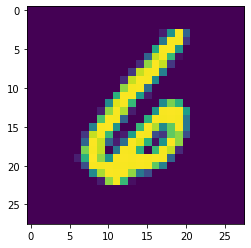

label:6


In [4]:
# Showing image example
def show_img(img):
    img = img/2 +0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

random_idx =  random.randint(0, len(trainset))
image, label = trainset[random_idx]
show_img(image)
print(f'label:{label}')

In [5]:
print('max value: ', trainset[random_idx][0].max())
print('min value: ', trainset[random_idx][0].min())

max value:  tensor(1.)
min value:  tensor(-1.)


In [6]:
# Explore shape of data
X_train, y_train = next(iter(trainloader))
print(X_train.shape, y_train.shape)
# # print the class of the image
# print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

torch.Size([4, 1, 28, 28]) torch.Size([4])


## Preparing data

In [7]:
y_train

tensor([4, 1, 6, 5])

## Create model

In [8]:

class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x

model= Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


## Training the model

In [9]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

In [10]:
def get_accuracy (y_true, y_pred):
    return (y_pred == y_true).sum().item()/len(y_true)

def train_fn(data_loader, model, optimizer, device):
    model.train()
    final_loss = 0.0
    for i, data in enumerate(tqdm(data_loader, total = len(data_loader))):
        # get input, and send to device
        inputs, labels = data[0].to(device), data[1].to(device) #, torch.float, , dtype=torch.int64
        # zero the gradient
        optimizer.zero_grad()

        # forward
        outputs = model(inputs) 
        _, pred_labels = torch.max(outputs.data, 1)
        loss = loss_fn(outputs, labels)

        # backward
        loss.backward()
        optimizer.step()
        
        # print loss every 1000 steps
        if (i+1) % 1000 == 0:
            print(f'Step [{i+1}/{len(data_loader)}]: Loss = {loss.item()}, Accuracy = {get_accuracy(labels, pred_labels)}')

        # save loss
        final_loss +=loss.item()
    return final_loss/len(data_loader)


def eval_fn(data_loader, model):
    model.eval()
    total = 0
    correct = 0
    final_loss = 0.0
    predictions = []
    with torch.no_grad():
        for data in tqdm(data_loader, total = len(data_loader)):
            inputs, labels = data
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            final_loss +=loss.item()

            _, pred_labels = torch.max(outputs.data, 1)
            predictions.append(pred_labels)
            # print('labels.size(0)', labels.size(0))
            total+= 1 #labels.size(0)
            correct+= get_accuracy(labels, pred_labels)
            # print(f'correct / total: {correct} / {total}')

    return final_loss/len(data_loader), correct / total, predictions

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)    

train_loss_values, validation_loss_values = [], []
best_loss = np.inf

for epoch in range(epochs):
    train_loss = train_fn(trainloader, model, optimizer, device)
    train_loss_values.append(train_loss)
    
    val_loss, val_accuracy, _ = eval_fn(testloader, model)
    validation_loss_values.append(val_loss)

    # saving the best model
    checkpoint_p = './mnist_net.pth'
    if val_loss < best_loss:
        torch.save(model.state_dict(), checkpoint_p)
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Epoch {epoch+1}/{epochs}: Train loss = {train_loss}, Validation loss = {val_loss}, Validation accuracy: {val_accuracy:.4f}')


  0%|          | 0/15000 [00:00<?, ?it/s]C:\Users\huyen\AppData\Local\Temp\ipykernel_4024\4117551951.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))
  7%|▋         | 1028/15000 [00:05<01:19, 175.24it/s]

Step [1000/15000]: Loss = 2.198029041290283, Accuracy = 0.25


 14%|█▎        | 2026/15000 [00:10<01:06, 195.63it/s]

Step [2000/15000]: Loss = 2.166931390762329, Accuracy = 0.25


 20%|██        | 3034/15000 [00:16<01:06, 179.08it/s]

Step [3000/15000]: Loss = 1.4907310009002686, Accuracy = 1.0


 27%|██▋       | 4020/15000 [00:21<01:03, 172.05it/s]

Step [4000/15000]: Loss = 1.6493302583694458, Accuracy = 0.75


 34%|███▎      | 5029/15000 [00:27<00:53, 186.42it/s]

Step [5000/15000]: Loss = 1.586272954940796, Accuracy = 1.0


 40%|████      | 6033/15000 [00:33<00:50, 178.80it/s]

Step [6000/15000]: Loss = 1.6576120853424072, Accuracy = 0.75


 47%|████▋     | 7020/15000 [00:39<00:48, 165.73it/s]

Step [7000/15000]: Loss = 1.9402997493743896, Accuracy = 0.5


 53%|█████▎    | 8016/15000 [00:45<00:37, 185.87it/s]

Step [8000/15000]: Loss = 1.493037223815918, Accuracy = 1.0


 60%|██████    | 9018/15000 [00:52<00:44, 133.60it/s]

Step [9000/15000]: Loss = 1.706618309020996, Accuracy = 0.75


 67%|██████▋   | 10032/15000 [00:58<00:28, 177.06it/s]

Step [10000/15000]: Loss = 1.4625730514526367, Accuracy = 1.0


 73%|███████▎  | 11024/15000 [01:03<00:21, 181.10it/s]

Step [11000/15000]: Loss = 1.4622876644134521, Accuracy = 1.0


 80%|████████  | 12019/15000 [01:09<00:20, 148.57it/s]

Step [12000/15000]: Loss = 1.5440301895141602, Accuracy = 1.0


 87%|████████▋ | 13007/15000 [01:18<00:13, 151.89it/s]

Step [13000/15000]: Loss = 1.5067341327667236, Accuracy = 1.0


 94%|█████████▎| 14029/15000 [01:24<00:05, 179.77it/s]

Step [14000/15000]: Loss = 1.4633760452270508, Accuracy = 1.0


100%|██████████| 15000/15000 [01:30<00:00, 166.43it/s]


Step [15000/15000]: Loss = 1.5066430568695068, Accuracy = 1.0


100%|██████████| 2500/2500 [00:06<00:00, 377.36it/s]


Epoch 1/10: Train loss = 1.7294988650480907, Validation loss = 1.5645230251789093, Validation accuracy: 0.9073


  7%|▋         | 1019/15000 [00:06<01:17, 179.68it/s]

Step [1000/15000]: Loss = 1.471744179725647, Accuracy = 1.0


 13%|█▎        | 2019/15000 [00:12<01:13, 177.60it/s]

Step [2000/15000]: Loss = 1.491271734237671, Accuracy = 1.0


 20%|██        | 3027/15000 [00:17<01:06, 179.06it/s]

Step [3000/15000]: Loss = 1.525251865386963, Accuracy = 1.0


 27%|██▋       | 4025/15000 [00:23<00:59, 184.60it/s]

Step [4000/15000]: Loss = 1.7295100688934326, Accuracy = 0.75


 34%|███▎      | 5031/15000 [00:29<00:55, 179.99it/s]

Step [5000/15000]: Loss = 1.7173551321029663, Accuracy = 0.75


 40%|████      | 6020/15000 [00:35<00:47, 187.66it/s]

Step [6000/15000]: Loss = 1.4611743688583374, Accuracy = 1.0


 47%|████▋     | 7024/15000 [00:41<00:49, 160.16it/s]

Step [7000/15000]: Loss = 1.463026523590088, Accuracy = 1.0


 53%|█████▎    | 8015/15000 [00:47<00:42, 164.80it/s]

Step [8000/15000]: Loss = 1.4623783826828003, Accuracy = 1.0


 60%|██████    | 9026/15000 [00:54<00:41, 144.97it/s]

Step [9000/15000]: Loss = 1.4645942449569702, Accuracy = 1.0


 67%|██████▋   | 10017/15000 [01:03<00:34, 144.97it/s]

Step [10000/15000]: Loss = 1.4616549015045166, Accuracy = 1.0


 74%|███████▎  | 11037/15000 [01:10<00:20, 191.97it/s]

Step [11000/15000]: Loss = 1.4618505239486694, Accuracy = 1.0


 80%|████████  | 12014/15000 [01:20<00:23, 129.45it/s]

Step [12000/15000]: Loss = 1.4612901210784912, Accuracy = 1.0


 87%|████████▋ | 13034/15000 [01:27<00:11, 175.49it/s]

Step [13000/15000]: Loss = 1.711122751235962, Accuracy = 0.75


 94%|█████████▎| 14032/15000 [01:34<00:06, 156.04it/s]

Step [14000/15000]: Loss = 1.462541937828064, Accuracy = 1.0


100%|██████████| 15000/15000 [01:39<00:00, 150.42it/s]


Step [15000/15000]: Loss = 1.465790867805481, Accuracy = 1.0


100%|██████████| 2500/2500 [00:05<00:00, 439.01it/s]


Epoch 2/10: Train loss = 1.557517002360026, Validation loss = 1.5458652329444886, Validation accuracy: 0.9187


  7%|▋         | 1022/15000 [00:06<01:16, 182.82it/s]

Step [1000/15000]: Loss = 1.6601194143295288, Accuracy = 0.75


 14%|█▎        | 2033/15000 [00:13<01:21, 160.03it/s]

Step [2000/15000]: Loss = 1.461249589920044, Accuracy = 1.0


 20%|██        | 3036/15000 [00:21<01:09, 172.70it/s]

Step [3000/15000]: Loss = 1.487540364265442, Accuracy = 1.0


 27%|██▋       | 4026/15000 [00:27<00:59, 184.13it/s]

Step [4000/15000]: Loss = 1.975407361984253, Accuracy = 0.5


 34%|███▎      | 5028/15000 [00:32<00:53, 185.80it/s]

Step [5000/15000]: Loss = 1.461979627609253, Accuracy = 1.0


 40%|████      | 6021/15000 [00:38<00:52, 172.30it/s]

Step [6000/15000]: Loss = 1.7877864837646484, Accuracy = 0.75


 47%|████▋     | 7004/15000 [00:45<01:23, 96.33it/s] 

Step [7000/15000]: Loss = 1.4630340337753296, Accuracy = 1.0


 54%|█████▎    | 8027/15000 [00:55<00:53, 131.07it/s]

Step [8000/15000]: Loss = 1.461287260055542, Accuracy = 1.0


 60%|██████    | 9022/15000 [01:00<00:31, 186.85it/s]

Step [9000/15000]: Loss = 1.4612101316452026, Accuracy = 1.0


 67%|██████▋   | 10027/15000 [01:07<00:27, 180.01it/s]

Step [10000/15000]: Loss = 1.4613583087921143, Accuracy = 1.0


 74%|███████▎  | 11033/15000 [01:13<00:23, 170.15it/s]

Step [11000/15000]: Loss = 1.4614421129226685, Accuracy = 1.0


 80%|████████  | 12014/15000 [01:19<00:20, 146.20it/s]

Step [12000/15000]: Loss = 1.4611989259719849, Accuracy = 1.0


 87%|████████▋ | 13020/15000 [01:28<00:14, 134.13it/s]

Step [13000/15000]: Loss = 1.4612261056900024, Accuracy = 1.0


 93%|█████████▎| 14019/15000 [01:35<00:05, 165.78it/s]

Step [14000/15000]: Loss = 1.4625279903411865, Accuracy = 1.0


100%|██████████| 15000/15000 [01:41<00:00, 147.47it/s]


Step [15000/15000]: Loss = 1.487336277961731, Accuracy = 1.0


100%|██████████| 2500/2500 [00:07<00:00, 345.92it/s]


Epoch 3/10: Train loss = 1.5357047307809193, Validation loss = 1.52625955491066, Validation accuracy: 0.9376


  7%|▋         | 1031/15000 [00:06<01:15, 185.78it/s]

Step [1000/15000]: Loss = 1.7110873460769653, Accuracy = 0.75


 14%|█▎        | 2028/15000 [00:11<01:07, 192.36it/s]

Step [2000/15000]: Loss = 1.5309287309646606, Accuracy = 1.0


 20%|██        | 3031/15000 [00:17<01:10, 170.26it/s]

Step [3000/15000]: Loss = 1.4634908437728882, Accuracy = 1.0


 27%|██▋       | 4020/15000 [00:22<00:59, 184.58it/s]

Step [4000/15000]: Loss = 1.4737274646759033, Accuracy = 1.0


 34%|███▎      | 5028/15000 [00:28<00:53, 186.83it/s]

Step [5000/15000]: Loss = 1.472447156906128, Accuracy = 1.0


 40%|████      | 6013/15000 [00:33<00:47, 187.50it/s]

Step [6000/15000]: Loss = 1.4613269567489624, Accuracy = 1.0


 47%|████▋     | 7018/15000 [00:38<00:41, 190.38it/s]

Step [7000/15000]: Loss = 1.4612151384353638, Accuracy = 1.0


 53%|█████▎    | 8016/15000 [00:46<01:21, 86.06it/s] 

Step [8000/15000]: Loss = 1.4618024826049805, Accuracy = 1.0


 60%|██████    | 9012/15000 [00:56<00:53, 112.47it/s]

Step [9000/15000]: Loss = 1.4692316055297852, Accuracy = 1.0


 67%|██████▋   | 10012/15000 [01:06<00:42, 117.88it/s]

Step [10000/15000]: Loss = 1.4617202281951904, Accuracy = 1.0


 73%|███████▎  | 11015/15000 [01:15<00:35, 111.64it/s]

Step [11000/15000]: Loss = 1.4613703489303589, Accuracy = 1.0


 80%|████████  | 12017/15000 [01:24<00:30, 96.41it/s] 

Step [12000/15000]: Loss = 1.7112267017364502, Accuracy = 0.75


 87%|████████▋ | 13020/15000 [01:34<00:17, 115.31it/s]

Step [13000/15000]: Loss = 1.4612826108932495, Accuracy = 1.0


 93%|█████████▎| 14017/15000 [01:45<00:10, 91.34it/s] 

Step [14000/15000]: Loss = 1.9248907566070557, Accuracy = 0.5


100%|██████████| 15000/15000 [01:55<00:00, 129.78it/s]


Step [15000/15000]: Loss = 1.4612010717391968, Accuracy = 1.0


100%|██████████| 2500/2500 [00:09<00:00, 266.37it/s]


Epoch 4/10: Train loss = 1.521540516781807, Validation loss = 1.517813761949539, Validation accuracy: 0.9459


  7%|▋         | 1017/15000 [00:09<01:58, 117.51it/s]

Step [1000/15000]: Loss = 1.4611588716506958, Accuracy = 1.0


 13%|█▎        | 2012/15000 [00:19<02:20, 92.67it/s] 

Step [2000/15000]: Loss = 1.594508171081543, Accuracy = 0.75


 20%|██        | 3015/15000 [00:32<02:18, 86.58it/s] 

Step [3000/15000]: Loss = 1.462964653968811, Accuracy = 1.0


 27%|██▋       | 4012/15000 [00:41<01:32, 119.00it/s]

Step [4000/15000]: Loss = 1.4614702463150024, Accuracy = 1.0


 33%|███▎      | 5009/15000 [00:50<01:34, 106.15it/s]

Step [5000/15000]: Loss = 1.4611523151397705, Accuracy = 1.0


 40%|████      | 6011/15000 [01:00<01:23, 108.20it/s]

Step [6000/15000]: Loss = 1.461230993270874, Accuracy = 1.0


 47%|████▋     | 7015/15000 [01:09<01:06, 119.28it/s]

Step [7000/15000]: Loss = 1.4611554145812988, Accuracy = 1.0


 53%|█████▎    | 8013/15000 [01:18<01:18, 88.89it/s] 

Step [8000/15000]: Loss = 1.4612184762954712, Accuracy = 1.0


 60%|██████    | 9014/15000 [01:28<00:55, 107.32it/s]

Step [9000/15000]: Loss = 1.4624402523040771, Accuracy = 1.0


 67%|██████▋   | 10012/15000 [01:36<00:41, 119.90it/s]

Step [10000/15000]: Loss = 1.4611735343933105, Accuracy = 1.0


 73%|███████▎  | 11024/15000 [01:45<00:31, 127.34it/s]

Step [11000/15000]: Loss = 1.6829496622085571, Accuracy = 0.75


 80%|████████  | 12018/15000 [01:54<00:23, 124.41it/s]

Step [12000/15000]: Loss = 1.5011729001998901, Accuracy = 1.0


 87%|████████▋ | 13016/15000 [02:02<00:18, 108.04it/s]

Step [13000/15000]: Loss = 1.461611032485962, Accuracy = 1.0


 93%|█████████▎| 14020/15000 [02:11<00:08, 121.98it/s]

Step [14000/15000]: Loss = 1.4974167346954346, Accuracy = 1.0


100%|██████████| 15000/15000 [02:19<00:00, 107.53it/s]


Step [15000/15000]: Loss = 1.4611976146697998, Accuracy = 1.0


100%|██████████| 2500/2500 [00:09<00:00, 269.67it/s]


Epoch 5/10: Train loss = 1.5126534403324128, Validation loss = 1.508762629175186, Validation accuracy: 0.9539


  7%|▋         | 1024/15000 [00:09<01:56, 120.35it/s]

Step [1000/15000]: Loss = 1.461172103881836, Accuracy = 1.0


 13%|█▎        | 2023/15000 [00:17<01:43, 124.91it/s]

Step [2000/15000]: Loss = 1.6365283727645874, Accuracy = 0.75


 20%|██        | 3022/15000 [00:26<01:39, 119.95it/s]

Step [3000/15000]: Loss = 1.56043541431427, Accuracy = 1.0


 27%|██▋       | 4020/15000 [00:34<01:32, 118.67it/s]

Step [4000/15000]: Loss = 1.4612758159637451, Accuracy = 1.0


 33%|███▎      | 5017/15000 [00:43<01:23, 119.66it/s]

Step [5000/15000]: Loss = 1.4826480150222778, Accuracy = 1.0


 40%|████      | 6013/15000 [00:52<01:40, 89.32it/s] 

Step [6000/15000]: Loss = 1.7098331451416016, Accuracy = 0.75


 47%|████▋     | 7021/15000 [01:01<01:04, 124.60it/s]

Step [7000/15000]: Loss = 1.4877336025238037, Accuracy = 1.0


 53%|█████▎    | 8012/15000 [01:09<00:56, 123.90it/s]

Step [8000/15000]: Loss = 1.461537480354309, Accuracy = 1.0


 60%|██████    | 9015/15000 [01:17<00:53, 111.79it/s]

Step [9000/15000]: Loss = 1.4611501693725586, Accuracy = 1.0


 67%|██████▋   | 10015/15000 [01:26<00:41, 119.87it/s]

Step [10000/15000]: Loss = 1.6974267959594727, Accuracy = 0.75


 73%|███████▎  | 11021/15000 [01:35<00:31, 124.94it/s]

Step [11000/15000]: Loss = 1.468501091003418, Accuracy = 1.0


 80%|████████  | 12020/15000 [01:43<00:24, 123.19it/s]

Step [12000/15000]: Loss = 1.4611620903015137, Accuracy = 1.0


 87%|████████▋ | 13011/15000 [01:52<00:20, 95.86it/s] 

Step [13000/15000]: Loss = 1.464105248451233, Accuracy = 1.0


 93%|█████████▎| 14019/15000 [02:01<00:09, 101.09it/s]

Step [14000/15000]: Loss = 1.4614278078079224, Accuracy = 1.0


100%|██████████| 15000/15000 [02:10<00:00, 115.30it/s]


Step [15000/15000]: Loss = 1.5460656881332397, Accuracy = 1.0


100%|██████████| 2500/2500 [00:08<00:00, 279.55it/s]


Epoch 6/10: Train loss = 1.5058301878213882, Validation loss = 1.5040857208251952, Validation accuracy: 0.9588


  7%|▋         | 1016/15000 [00:09<02:12, 105.17it/s]

Step [1000/15000]: Loss = 1.6457061767578125, Accuracy = 0.75


 13%|█▎        | 2018/15000 [00:19<02:03, 104.93it/s]

Step [2000/15000]: Loss = 1.4611680507659912, Accuracy = 1.0


 20%|██        | 3019/15000 [00:28<01:42, 117.16it/s]

Step [3000/15000]: Loss = 1.4611797332763672, Accuracy = 1.0


 27%|██▋       | 4012/15000 [00:40<01:47, 102.56it/s]

Step [4000/15000]: Loss = 1.6526435613632202, Accuracy = 0.75


 33%|███▎      | 5022/15000 [00:49<01:36, 103.48it/s]

Step [5000/15000]: Loss = 1.5110955238342285, Accuracy = 1.0


 40%|████      | 6012/15000 [00:59<01:13, 122.03it/s]

Step [6000/15000]: Loss = 1.6718388795852661, Accuracy = 0.75


 47%|████▋     | 7013/15000 [01:08<01:09, 115.20it/s]

Step [7000/15000]: Loss = 1.4618840217590332, Accuracy = 1.0


 53%|█████▎    | 8017/15000 [01:18<01:02, 112.53it/s]

Step [8000/15000]: Loss = 1.4611903429031372, Accuracy = 1.0


 60%|██████    | 9008/15000 [01:30<01:24, 70.57it/s] 

Step [9000/15000]: Loss = 1.4611510038375854, Accuracy = 1.0


 67%|██████▋   | 10013/15000 [01:43<01:01, 80.92it/s]

Step [10000/15000]: Loss = 1.462140679359436, Accuracy = 1.0


 73%|███████▎  | 11017/15000 [01:54<00:37, 105.24it/s]

Step [11000/15000]: Loss = 1.4611648321151733, Accuracy = 1.0


 80%|████████  | 12019/15000 [02:04<00:28, 104.72it/s]

Step [12000/15000]: Loss = 1.461891770362854, Accuracy = 1.0


 87%|████████▋ | 13010/15000 [02:14<00:18, 109.74it/s]

Step [13000/15000]: Loss = 1.468753695487976, Accuracy = 1.0


 93%|█████████▎| 14015/15000 [02:25<00:10, 90.94it/s] 

Step [14000/15000]: Loss = 1.461214542388916, Accuracy = 1.0


100%|██████████| 15000/15000 [02:37<00:00, 95.06it/s]


Step [15000/15000]: Loss = 1.7111481428146362, Accuracy = 0.75


100%|██████████| 2500/2500 [00:10<00:00, 245.46it/s]


Epoch 7/10: Train loss = 1.4999714950402578, Validation loss = 1.500348232126236, Validation accuracy: 0.9630


  7%|▋         | 1015/15000 [00:10<02:21, 98.96it/s]

Step [1000/15000]: Loss = 1.4612171649932861, Accuracy = 1.0


 13%|█▎        | 2015/15000 [00:19<02:08, 101.13it/s]

Step [2000/15000]: Loss = 1.6376396417617798, Accuracy = 0.75


 20%|██        | 3013/15000 [00:29<01:48, 110.53it/s]

Step [3000/15000]: Loss = 1.4612663984298706, Accuracy = 1.0


 27%|██▋       | 4013/15000 [00:38<01:37, 113.25it/s]

Step [4000/15000]: Loss = 1.701658010482788, Accuracy = 0.75


 33%|███▎      | 5012/15000 [00:49<01:35, 105.08it/s]

Step [5000/15000]: Loss = 1.4653692245483398, Accuracy = 1.0


 40%|████      | 6012/15000 [00:58<01:20, 111.56it/s]

Step [6000/15000]: Loss = 1.4679181575775146, Accuracy = 1.0


 47%|████▋     | 7013/15000 [01:08<01:22, 97.29it/s] 

Step [7000/15000]: Loss = 1.4622055292129517, Accuracy = 1.0


 53%|█████▎    | 8017/15000 [01:17<01:07, 104.01it/s]

Step [8000/15000]: Loss = 1.4611880779266357, Accuracy = 1.0


 60%|██████    | 9014/15000 [01:27<00:55, 108.37it/s]

Step [9000/15000]: Loss = 1.691835880279541, Accuracy = 0.75


 67%|██████▋   | 10017/15000 [01:36<00:45, 109.55it/s]

Step [10000/15000]: Loss = 1.4611575603485107, Accuracy = 1.0


 73%|███████▎  | 11018/15000 [01:46<00:36, 108.74it/s]

Step [11000/15000]: Loss = 1.4801076650619507, Accuracy = 1.0


 80%|████████  | 12021/15000 [01:55<00:26, 111.35it/s]

Step [12000/15000]: Loss = 1.4613503217697144, Accuracy = 1.0


 87%|████████▋ | 13017/15000 [02:03<00:16, 116.87it/s]

Step [13000/15000]: Loss = 1.462620735168457, Accuracy = 1.0


 93%|█████████▎| 14020/15000 [02:12<00:07, 124.55it/s]

Step [14000/15000]: Loss = 1.4614884853363037, Accuracy = 1.0


100%|██████████| 15000/15000 [02:20<00:00, 106.79it/s]


Step [15000/15000]: Loss = 1.4613240957260132, Accuracy = 1.0


100%|██████████| 2500/2500 [00:08<00:00, 281.35it/s]


Epoch 8/10: Train loss = 1.496337776684761, Validation loss = 1.5010079852104188, Validation accuracy: 0.9623


  7%|▋         | 1016/15000 [00:08<02:08, 108.69it/s]

Step [1000/15000]: Loss = 1.4613597393035889, Accuracy = 1.0


 13%|█▎        | 2021/15000 [00:17<01:47, 120.85it/s]

Step [2000/15000]: Loss = 1.461169958114624, Accuracy = 1.0


 20%|██        | 3016/15000 [00:25<01:41, 117.90it/s]

Step [3000/15000]: Loss = 1.4611504077911377, Accuracy = 1.0


 27%|██▋       | 4013/15000 [00:34<01:33, 117.89it/s]

Step [4000/15000]: Loss = 1.4617128372192383, Accuracy = 1.0


 33%|███▎      | 5015/15000 [00:42<01:21, 123.25it/s]

Step [5000/15000]: Loss = 1.4611551761627197, Accuracy = 1.0


 40%|████      | 6017/15000 [00:50<01:14, 121.10it/s]

Step [6000/15000]: Loss = 1.6475961208343506, Accuracy = 0.75


 47%|████▋     | 7014/15000 [00:59<01:05, 121.70it/s]

Step [7000/15000]: Loss = 1.4611501693725586, Accuracy = 1.0


 53%|█████▎    | 8019/15000 [01:07<00:56, 123.71it/s]

Step [8000/15000]: Loss = 1.4622509479522705, Accuracy = 1.0


 60%|██████    | 9018/15000 [01:16<00:58, 102.59it/s]

Step [9000/15000]: Loss = 1.4611517190933228, Accuracy = 1.0


 67%|██████▋   | 10010/15000 [01:25<00:36, 137.94it/s]

Step [10000/15000]: Loss = 1.461153507232666, Accuracy = 1.0


 73%|███████▎  | 11018/15000 [01:33<00:31, 125.52it/s]

Step [11000/15000]: Loss = 1.4640203714370728, Accuracy = 1.0


 80%|████████  | 12020/15000 [01:42<00:25, 117.65it/s]

Step [12000/15000]: Loss = 1.7024424076080322, Accuracy = 0.75


 87%|████████▋ | 13020/15000 [01:50<00:16, 118.00it/s]

Step [13000/15000]: Loss = 1.4611536264419556, Accuracy = 1.0


 94%|█████████▎| 14025/15000 [01:59<00:08, 120.97it/s]

Step [14000/15000]: Loss = 1.461151361465454, Accuracy = 1.0


100%|██████████| 15000/15000 [02:07<00:00, 117.80it/s]


Step [15000/15000]: Loss = 1.4611709117889404, Accuracy = 1.0


100%|██████████| 2500/2500 [00:09<00:00, 265.69it/s]


Epoch 9/10: Train loss = 1.4930524686733881, Validation loss = 1.4971026538848877, Validation accuracy: 0.9664


  7%|▋         | 1013/15000 [00:08<01:57, 119.12it/s]

Step [1000/15000]: Loss = 1.4616107940673828, Accuracy = 1.0


 13%|█▎        | 2014/15000 [00:17<01:53, 114.54it/s]

Step [2000/15000]: Loss = 1.478914499282837, Accuracy = 1.0


 20%|██        | 3019/15000 [00:25<01:38, 121.83it/s]

Step [3000/15000]: Loss = 1.4611510038375854, Accuracy = 1.0


 27%|██▋       | 4015/15000 [00:34<01:32, 118.64it/s]

Step [4000/15000]: Loss = 1.4612175226211548, Accuracy = 1.0


 33%|███▎      | 5020/15000 [00:42<01:21, 122.63it/s]

Step [5000/15000]: Loss = 1.4611530303955078, Accuracy = 1.0


 40%|████      | 6013/15000 [00:50<01:12, 124.79it/s]

Step [6000/15000]: Loss = 1.4611554145812988, Accuracy = 1.0


 47%|████▋     | 7011/15000 [00:59<01:14, 106.77it/s]

Step [7000/15000]: Loss = 1.8950951099395752, Accuracy = 0.5


 53%|█████▎    | 8019/15000 [01:08<00:57, 121.37it/s]

Step [8000/15000]: Loss = 1.4611501693725586, Accuracy = 1.0


 60%|██████    | 9025/15000 [01:15<00:41, 145.66it/s]

Step [9000/15000]: Loss = 1.4727189540863037, Accuracy = 1.0


 67%|██████▋   | 10033/15000 [01:21<00:26, 188.29it/s]

Step [10000/15000]: Loss = 1.461181879043579, Accuracy = 1.0


 74%|███████▎  | 11032/15000 [01:27<00:20, 197.58it/s]

Step [11000/15000]: Loss = 1.5574764013290405, Accuracy = 1.0


 80%|████████  | 12023/15000 [01:32<00:16, 185.59it/s]

Step [12000/15000]: Loss = 1.5272234678268433, Accuracy = 1.0


 87%|████████▋ | 13026/15000 [01:37<00:10, 182.32it/s]

Step [13000/15000]: Loss = 1.4611705541610718, Accuracy = 1.0


 94%|█████████▎| 14041/15000 [01:43<00:04, 196.48it/s]

Step [14000/15000]: Loss = 1.4612869024276733, Accuracy = 1.0


100%|██████████| 15000/15000 [01:48<00:00, 138.53it/s]


Step [15000/15000]: Loss = 1.4612420797348022, Accuracy = 1.0


100%|██████████| 2500/2500 [00:05<00:00, 463.86it/s]

Epoch 10/10: Train loss = 1.4899135030905406, Validation loss = 1.4914183937549592, Validation accuracy: 0.9711


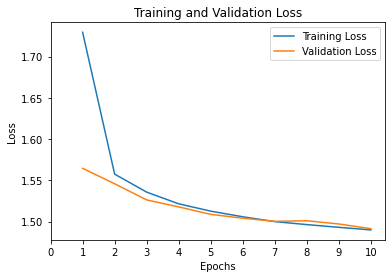

In [11]:
# Visualize the loss 
epochs = range(1, 11)
plt.plot(epochs, train_loss_values, label='Training Loss')
plt.plot(epochs, validation_loss_values, label='Validation Loss')
 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 11, 1))
 
plt.legend(loc='best')
plt.show()

In [12]:
# def get_accuracy (y_true, y_pred):
#     return (y_pred == y_true).sum().item()/len(y_true)

In [13]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# for epoch in range(epochs):
#     final_loss = 0.0
#     for i, data in enumerate(trainloader):
#         # get input, and send to device
#         inputs, labels = data[0].to(device), data[1].to(device)
#         # zero the gradient
#         optimizer.zero_grad()

#         # forward
#         outputs = model(inputs) 
#         _, pred_labels = torch.max(outputs.data, 1)
#         loss = loss_fn(outputs, labels)

#         # backward
#         loss.backward()
#         optimizer.step()
        
#         # print loss every 1000 steps
#         if (i+1) % 1000 == 0:
#             train_acc = get_accuracy(labels, pred_labels)
#             print(f'Step [{i+1}/{len(trainloader)}]: Loss = {loss.item()} - Accuracy = {train_acc}')

#         # save loss
#         final_loss +=loss.item()



In [14]:
# # Saving model
# model_saving_p = './mnist_net.pth'
# torch.save(model, model_saving_p)

## Testing the model


In [15]:
# model.load_state_dict(torch.load(model_saving_p))

# total = 0
# correct = 0

# with torch.no_grad():
#     for data in testloader:
#         inputs, labels = data
#         outputs = model(inputs)
#         _, pred_labels = torch.max(outputs.data, 1)
#         total+= 1#labels.size(0)
#         correct+= get_accuracy(labels, pred_labels)
        
#         # print(f'correct / total: {correct} / {total}')
# print(f'Accuracy on the test set: {correct / total}')
